## Import Packages, Load Data

In [154]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import time
migration_df = pd.read_csv('migration_dums.csv')
migration_df.set_index(['date_stamp','Province'],inplace=True)

# Look at the data

Patterns differ from state to state

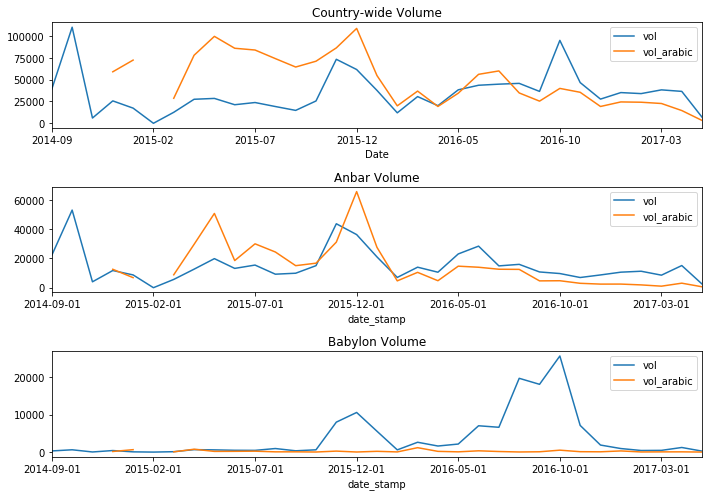

In [76]:
f,a=plt.subplots(3,1)
a[0].set_title("Country-wide Volume")
a[1].set_title("Anbar Volume")
a[2].set_title("Babylon Volume")
foo = migration_df.loc[:,['vol','vol_arabic','Date']].groupby('Date').sum()
foo.loc[:,['vol','vol_arabic']].plot(ax=a[0],figsize=(10,7))
foo = migration_df.loc[(slice(None),'Anbar'),['vol','vol_arabic']]
foo.reset_index('Province').plot(ax=a[1])
migration_df.loc[(slice(None),'Babylon'),['vol','vol_arabic']].reset_index('Province').plot(ax=a[2])
f.tight_layout()

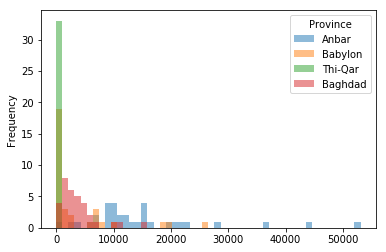

In [7]:
# f,a=plt.figure(figsize=(5,5))
vol_plot=migration_df.loc[:,['vol']].unstack(level="Province")
vol_plot.columns = vol_plot.columns.droplevel(0)
vol_plot.drop('Sulaymaniyah',axis=1,inplace=True)
ax =vol_plot.loc[:,['Anbar','Babylon','Thi-Qar','Baghdad']].plot(kind='hist',alpha=.5,bins=50)
# vol_plot.plot.density()
ax.figsize=(10,5)


# What do we learn?

* Variation over provinces

## If we ignore space: 
* May be that people tweet about and flee some provinces more than others, says nothing about <b>when</b> people flee

## IID violation
* Autocorrelation within space. Confidence estimates wrong. 

---

# What about time?

/home/law98/anaconda/envs/p3env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1127: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/home/law98/anaconda/envs/p3env/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1119: RuntimeWarning: invalid value encountered in double_scalars
  r[k] = (X[0:-k]*X[k:]).sum() / denom(k)


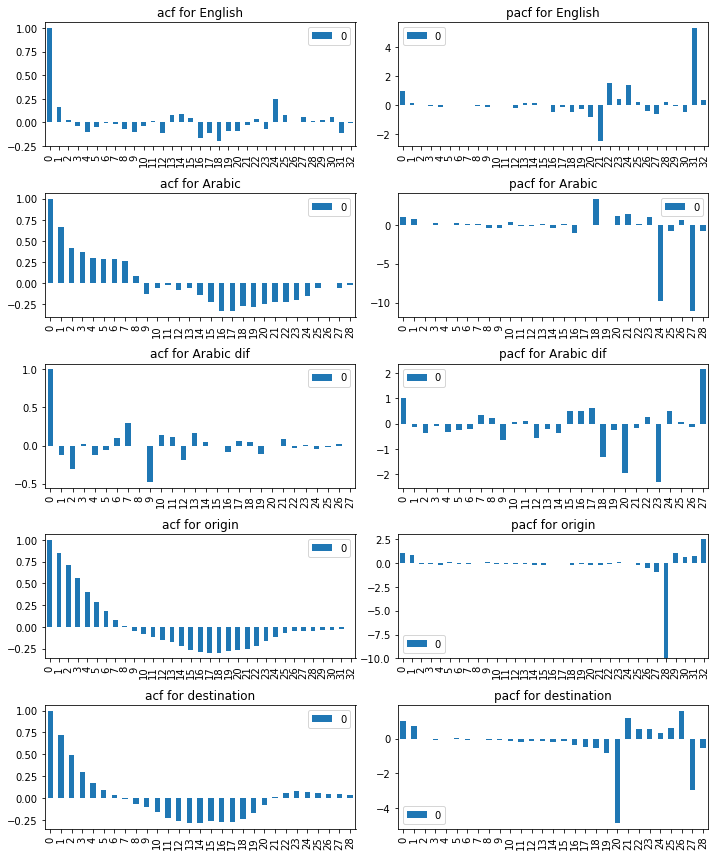

In [97]:
from statsmodels.tsa.stattools import acf, pacf
foo = migration_df.loc[:,['vol','vol_arabic','origin','destination','Date']].groupby('Date').sum()

f,axs = plt.subplots(5,2)
axs[0][0].set_title('acf for English')
axs[0][1].set_title('pacf for English')
axs[1][0].set_title('acf for Arabic')
axs[1][1].set_title('pacf for Arabic')
axs[2][0].set_title('acf for Arabic dif')
axs[2][1].set_title('pacf for Arabic dif')
axs[3][0].set_title('acf for origin')
axs[3][1].set_title('pacf for origin')
axs[4][0].set_title('acf for destination')
axs[4][1].set_title('pacf for destination')
a = acf(foo.vol)
a = pd.DataFrame([a]).T
a.plot(kind='bar',ax = axs[0][0],figsize=(10,12))
# foo = foo.dropna(axis=0)
a = pacf(foo.vol)
a = pd.DataFrame([a]).T
a = a.dropna(axis=0)
a.plot(kind='bar',ax = axs[0][1])

a = acf(foo.origin)
a = pd.DataFrame([a]).T
a.plot(kind='bar',ax = axs[3][0])

a = pacf(foo.origin)
a = pd.DataFrame([a]).T
a = a.dropna(axis=0)
a.plot(kind='bar',ax = axs[3][1],ylim=[-10,3])

foo = foo.dropna(axis=0)
a = acf(foo.destination)
a = pd.DataFrame([a]).T
a.plot(kind='bar',ax = axs[4][0])

a = pacf(foo.destination)
a = pd.DataFrame([a]).T
a = a.dropna(axis=0)
a.plot(kind='bar',ax = axs[4][1])


foo = foo.dropna(axis=0)
a = acf(foo.vol_arabic)
a = pd.DataFrame([a]).T
a.plot(kind='bar',ax = axs[1][0])

a = pacf(foo.vol_arabic)
a = pd.DataFrame([a]).T
a = a.dropna(axis=0)
a.plot(kind='bar',ax = axs[1][1])



foo['vol_arabic_dif'] = foo.vol_arabic- foo.vol_arabic.shift(1)
foo = foo.dropna(axis=0)
a = acf(foo.vol_arabic_dif)
a = pd.DataFrame([a]).T
a.plot(kind='bar',ax = axs[2][0])

a = pacf(foo.vol_arabic_dif)
a = pd.DataFrame([a]).T
a = a.dropna(axis=0)
a.plot(kind='bar',ax = axs[2][1])




f.tight_layout()



# What do we learn?
* Autocorrelation in time
* Some weird time stuff going on at later lags. 

## If we ignore time: 
* AR process, non-stationary data. Reduced predictive validity
* Spurious results more likely

## IID violation
* Autocorrelation within time. Confidence estimates wrong. 


# What does this mean?

* Don't know whether bivariate correlation estimates are noise or 0
* We care about where and when something happens, can't get that from country-level pooled estimates

___

# Solution:
* differencing, lags, fixed effects

___

# Fixed Effects: 
* Add a constant for every month, and every place. 
* If Anbar always has more tweets, compare Anbar against Anbar
### Why: 
* Control for unknowns to <b>isolate effect of the signal </b>



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.360
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.125
Date:                Thu, 14 Dec 2017   Prob (F-statistic):              0.400
Time:                        13:52:08   Log-Likelihood:                -5.2295
No. Observations:                   4   AIC:                             14.46
Df Residuals:                       2   BIC:                             13.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x              0.6000      0.566      1.061      0.4

/home/law98/anaconda/envs/p3env/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


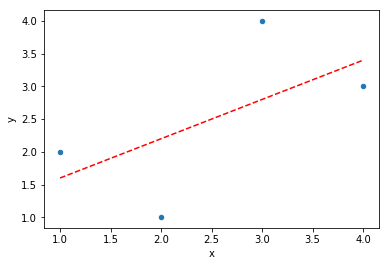

In [160]:
bar = pd.DataFrame([1,2,3,4],columns=['x'])
bar['y']=[2,1,4,3]
bar.plot.scatter('x','y')
bar['condition']=[1,1,0,0]
bar['c']=1
print(sm.OLS(bar.y,bar.loc[:,['x','c']]).fit().summary())
bar['fit1']=bar.x*.6+1
plt.plot(bar.x,bar.fit1,"r--")
print('\n\nCorrelation:',sp.stats.stats.pearsonr(bar.x,bar.y)[0])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.438e+29
Date:                Thu, 14 Dec 2017   Prob (F-statistic):           1.43e-15
Time:                        13:47:59   Log-Likelihood:                 130.60
No. Observations:                   4   AIC:                            -255.2
Df Residuals:                       1   BIC:                            -257.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x             -1.0000    3.2e-15  -3.12e+14      0.0

/home/law98/anaconda/envs/p3env/lib/python3.6/site-packages/statsmodels/stats/stattools.py:72: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  "samples were given." % int(n), ValueWarning)


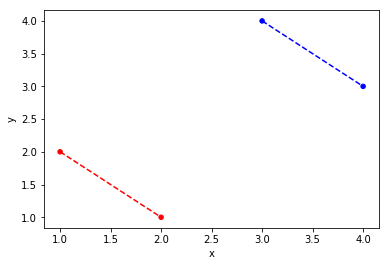

In [150]:
# bar.loc[bar.condition==1,['x','y']].plot.scatter('x','y')
print(sm.OLS(bar.y,bar.loc[:,['x','c','condition']]).fit().summary())
bar.plot.scatter('x','y',c=['r','r','b','b'])
bar['fit2']=7-bar.x
bar['fit3']=7-bar.x
bar['fit3']=bar.fit3 - 4
plt.plot(bar.loc[bar.condition==0,'x'],bar.loc[bar.condition==0,'fit2'],"b--")
plt.plot(bar.loc[bar.condition==1,'x'],bar.loc[bar.condition==1,'fit3'],"r--")



In context, imagine y is tweet volume, and x is some outcome of interest that occurs at the local level. We know that the tweet volume is higher in Anbar than Baghdad. In these circumstances, local effects would be mased with a bivariate correlation. 

Note also that, while it is a good idea to look at your data's distributions, you want to make these decisions before you start modeling if you can. You <i>can</i> lie with statistics. And human heuristics make it easy to justify. Protect yourself from yourself, so you don't. Think about model design before you look at results

# Takeaway: 
* Our final model will have a lot of other predictors and controls, but this model doesn't
* Can get around that by isolating the signal with fixed effects
* Look at the effect of a signal in Anbar, rather than comparing the effect of that signal in Anbar and while avoiding comparing it unduely to the effect in Baghdad. 
* "Partially pooled". Allow regional and temporal variation without multiple comparisions or iid violations with pooled. 
* Expect similar effects, with different magnitudes
* Could go all the way to random effects, allow each governorate to have have its own effect, drawn from a distribution, and estimate that distribution. But we don't have that much data here, might loose so much power than real results fade away.

# OLS vs GLM

## Count data
   * We know the data are count. Poisson <i> should </i>be our first guess 

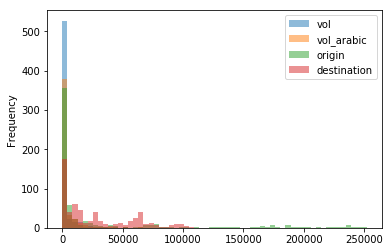

In [189]:
migration_df.loc[:,['vol','vol_arabic','origin','destination']].plot.hist(bins=60,alpha=.5)


### Those are some long tails...

In [188]:
spreads = migration_df.loc[:,['vol','vol_arabic','origin','destination','Orig_difs','Dest_difs']].mean()
spreads = pd.DataFrame(spreads,columns = ['mean'])
spreads['var'] = migration_df.loc[:,['vol','vol_arabic','origin','destination','Orig_difs','Dest_difs']].var(skipna=True)
spreads

,mean,var
vol,1909.838384,3.042682e+07
vol_arabic,3093.299569,4.894998e+07
origin,27618.069024,3.528855e+09
destination,27618.062290,8.389860e+08
Orig_difs,363.272569,1.142958e+07
Dest_difs,363.277778,7.059127e+06


### Poisson distributions have mean=variance.
### Use Negative Binomial instead to model mean and variance separately

# Negative Binomial Distribution is the most appropriate distribution for our outcome variables of interest. 

Note: there are also a lot of zeros, should probably run zero-inflated negative binomial, to model 0s as distinct processes. But that's harder in python, so we can check model fit to see if it's necessary or if we can get reasonable estimates without it.

___
# What's wrong with OLS?
## Homoskedasticity Assumption
* {k+r-1 \choose k}\cdot (1-p)^{r}p^{k}
* Variance changes as mean changes. Data are heteroskedastic. Since regression is essentially a way to measure variance, you have to account for the variance appropriately or your certainty estimates are wrng
## It doesn't fit the data. 
* Can predict negative numbers
* Different relationship between predictors and probability of observed outcome than a gaussian regression. 

In [238]:
dates =['14-09',
       '14-10', '14-11', '14-12', '15-01', '15-02', '15-03', '15-04',
       '15-05', '15-06', '15-07', '15-08', '15-09', '15-10', '15-11',
       '15-12', '16-01', '16-02', '16-03', '16-04', '16-05', '16-06',
       '16-07', '16-08', '16-09', '16-10', '16-11', '16-12', '17-01',
       '17-02', '17-03', '17-04', '17-05',]
provinces = migration_df.index.get_level_values(1).unique()
yvar = 'origin'
xvars = ['vol','origin_lag']
xvars.extend(provinces)
xvars.extend(dates)
glm =False

model_olsg = sm.GLM(migration_df.loc[:,yvar],
                migration_df.loc[:,xvars],missing='drop',
               family=sm.families.Gaussian(),
               )
model_nb = sm.GLM(migration_df.loc[:,yvar],
                migration_df.loc[:,xvars],missing='drop',
               family=sm.families.NegativeBinomial(),
               )
model_ols = sm.OLS(migration_df.loc[:,yvar],
                migration_df.loc[:,xvars],missing='drop')
if glm:
    results_nb = model_nb.fit()
    print(results_nb.summary())
else:
    results_olsg = model_olsg.fit()
    results_ols = model_ols.fit()
    print(results_ols.summary())
    

                            OLS Regression Results                            
Dep. Variable:                 origin   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3960.
Date:                Thu, 14 Dec 2017   Prob (F-statistic):               0.00
Time:                        14:55:04   Log-Likelihood:                -5444.0
No. Observations:                 576   AIC:                         1.099e+04
Df Residuals:                     525   BIC:                         1.121e+04
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
vol              0.1765      0.035      4.973   

# Just doesn't fit:

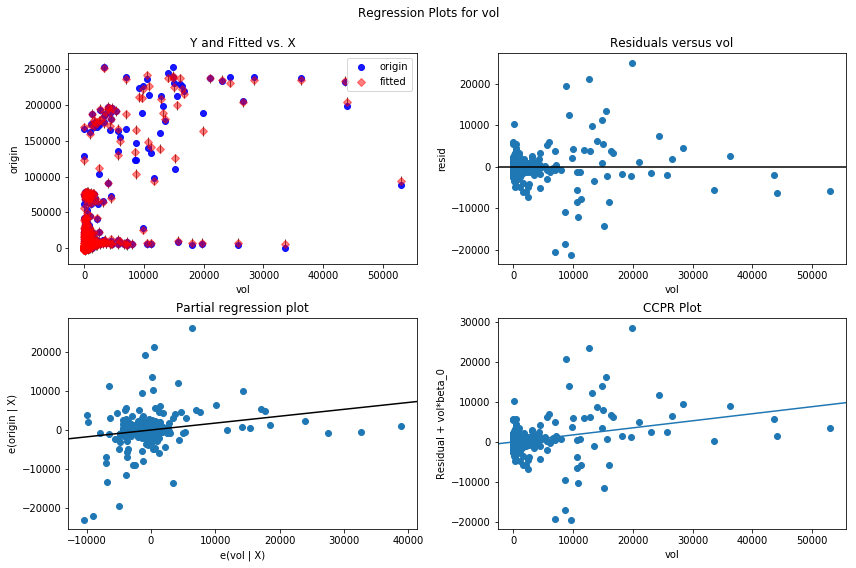

In [239]:
fig = plt.figure(figsize=(12,8))
fig=sm.graphics.plot_regress_exog(results_ols, "vol",fig=fig)

# Heteroskedastic

Text(0.5,0,'Fitted values')

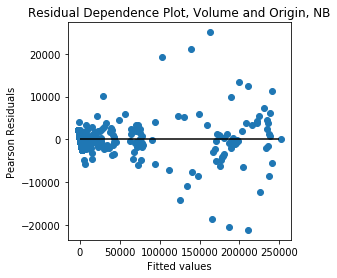

In [243]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(results_olsg.mu, results_olsg.resid_response)
# ax.hlines(0, 0, 3000000)
# ax.set_xlim(0, 70000)
# ax.set_ylim(0, 70000)
ax.hlines(0, 0, 250000)
ax.set_title('Residual Dependence Plot, Volume and Origin, NB')
ax.set_ylabel('Pearson Residuals')
ax.set_xlabel('Fitted values')

# And now with a GLM:

Note: statsmodels isn't as sophisticated as many of the packages in R, and the negative binomial regression is still a little new. Converges with the MASS package in R, but has trouble with Statsmodels. I also just trust MASS  a little more than statsmodels. So the results are pasted below: 


Call:
glm.nb(formula = origin ~ vol + origin_lag + Anbar + Babylon + 
    Baghdad + Basrah + Dahuk + Diyala + Erbil + Kerbala + Kirkuk + 
    Missan + Muthanna + Najaf + Ninewa + Qadissiya + Salah.al.Din + 
    Sulaymaniyah + Thi.Qar + Wassit + X14.10 + X14.11 + X14.12 + 
    X15.01 + X15.02 + X15.03 + X15.04 + X15.05 + X15.06 + X15.07 + 
    X15.08 + X15.09 + X15.10 + X15.11 + X15.12 + X16.01 + X16.02 + 
    X16.03 + X16.04 + X16.05 + X16.06 + X16.07 + X16.08 + X16.09 + 
    X16.10 + X16.11 + X16.12 + X17.01 + X17.02 + X17.03 + X17.04 - 
    1, data = data, init.theta = 1.394043988, link = log)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.9672  -0.6948  -0.1600   0.1415   3.8842  

```Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
vol           2.301e-05  9.822e-06   2.342 0.019157 *  
origin_lag    1.177e-05  2.679e-06   4.394 1.11e-05 ***
Anbar         9.456e+00  5.647e-01  16.745  < 2e-16 ***
Babylon       8.183e+00  3.059e-01  26.749  < 2e-16 ***
Baghdad       8.718e+00  3.065e-01  28.444  < 2e-16 ***
Basrah       -1.776e-01  3.503e-01  -0.507 0.612050    
Dahuk        -4.087e+00  1.043e+00  -3.918 8.95e-05 ***
Diyala        9.614e+00  3.158e-01  30.441  < 2e-16 ***
Erbil         7.699e+00  3.069e-01  25.089  < 2e-16 ***
Kerbala      -3.739e+01  1.125e+07   0.000 0.999997    
Kirkuk        9.624e+00  3.124e-01  30.808  < 2e-16 ***
Missan        8.451e-02  3.415e-01   0.247 0.804572    
Muthanna     -3.739e+01  1.125e+07   0.000 0.999997    
Najaf        -2.089e+00  4.998e-01  -4.179 2.92e-05 ***
Ninewa        9.628e+00  5.818e-01  16.549  < 2e-16 ***
Qadissiya     1.482e+00  3.154e-01   4.700 2.60e-06 ***
Salah.al.Din  1.018e+01  3.587e-01  28.377  < 2e-16 ***
Sulaymaniyah -1.625e+00  4.444e-01  -3.656 0.000256 ***
Thi.Qar      -4.126e+00  1.062e+00  -3.884 0.000103 ***
Wassit       -3.739e+01  1.125e+07   0.000 0.999997    
X14.10        1.383e-01  3.999e-01   0.346 0.729497    
X14.11        6.279e-01  3.805e-01   1.650 0.098899 .  
X14.12        6.501e-01  3.806e-01   1.708 0.087623 .  
X15.01        7.865e-01  3.785e-01   2.078 0.037704 *  
X15.02        1.454e+00  3.718e-01   3.912 9.14e-05 ***
X15.03        1.516e+00  3.712e-01   4.085 4.41e-05 ***
X15.04        1.433e+00  3.723e-01   3.849 0.000119 ***
X15.05        1.718e-01  3.819e-01   0.450 0.652739    
X15.06        1.581e-01  3.815e-01   0.415 0.678462    
X15.07        1.622e-01  3.815e-01   0.425 0.670676    
X15.08        1.561e-01  3.814e-01   0.409 0.682287    
X15.09        1.379e-01  3.815e-01   0.361 0.717814    
X15.10        2.568e+00  3.647e-01   7.041 1.90e-12 ***
X15.11        1.951e+00  3.722e-01   5.241 1.60e-07 ***
X15.12       -1.175e-01  3.872e-01  -0.304 0.761502    
X16.01       -1.209e-01  3.847e-01  -0.314 0.753366    
X16.02       -7.577e-02  3.834e-01  -0.198 0.843339    
X16.03       -1.287e-01  3.844e-01  -0.335 0.737728    
X16.04       -1.511e-01  3.843e-01  -0.393 0.694187    
X16.05       -2.037e-01  3.856e-01  -0.528 0.597330    
X16.06       -2.027e-01  3.859e-01  -0.525 0.599386    
X16.07       -2.204e-01  3.862e-01  -0.571 0.568232    
X16.08       -2.304e-01  3.864e-01  -0.596 0.550960    
X16.09       -2.075e-01  3.855e-01  -0.538 0.590401    
X16.10       -2.240e-01  3.943e-01  -0.568 0.569996    
X16.11       -9.720e-02  3.854e-01  -0.252 0.800856    
X16.12       -6.413e-02  3.836e-01  -0.167 0.867236    
X17.01       -3.999e-02  3.839e-01  -0.104 0.917048    
X17.02       -2.726e-02  3.837e-01  -0.071 0.943351    
X17.03        2.561e-02  3.837e-01   0.067 0.946770    
X17.04       -7.492e-02  3.843e-01  -0.195 0.845445    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for Negative Binomial(1.394) family taken to be 1)

    Null deviance: 2.8122e+07  on 576  degrees of freedom
Residual deviance: 4.7556e+02  on 525  degrees of freedom
  (18 observations deleted due to missingness)
AIC: 6307.7

Number of Fisher Scoring iterations: 1


              Theta:  1.394 
          Std. Err.:  0.127 
Warning while fitting theta: alternation limit reached 

 2 x log-likelihood:  -6203.692 
Warning message:
In glm.nb(origin ~ vol + origin_lag + Anbar + Babylon + Baghdad +  :
  alternation limit reached
```


# Transform residuals from NB GLM using DHARMa in R
```
> sim <- simulateResiduals(fittedModel = m1, n=500)
> plotSimulatedResiduals(simulationOutput = sim)```

In [247]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "resid.png")


# Results
### Understanding the signals
* Origin and Destination well correlated
* Localized Pos/Neg sentiment well correlated
* Localized Arabic/English volume well correlated
### Relationships
* Death/capita leading indicator of movement
* Volume in english and arabic a leading indicator of movement


# But why though? 
### Can we say anything about what the Twitter signals mean?
#### To understand the relationship between variables in explaining an outcome, add and remove them from the model
* Run the model with volume alone
* Run the model with volume and death/capita
* The significance and effect size of volume go down. Distribution moves toward 0. 
### This means that at least some of the movement explained by tweet volume operates through death. 